In [1114]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage.morphology as morph

In [1115]:
def plot_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [1116]:
prueba1 = cv2.imread('database/2_gt.pgm', cv2.IMREAD_UNCHANGED)

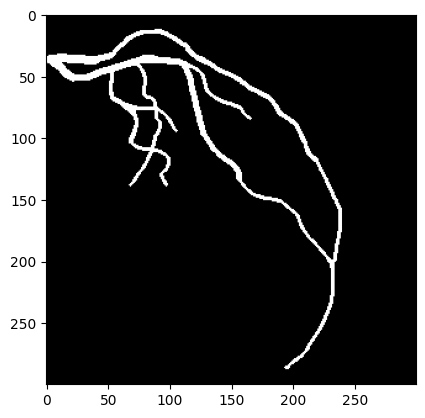

In [1117]:
plot_image(prueba1)

In [1118]:
def esqueletizar(imagen):
    return morph.skeletonize(imagen).astype(np.uint8)

In [1119]:
def closing(imagen, kernel):
    return morph.closing(imagen, kernel)

In [1120]:
def opening(imagen, kernel):
    return morph.opening(imagen, kernel)

In [1121]:
def erosion(imagen, kernel):
    return morph.erosion(imagen, kernel)

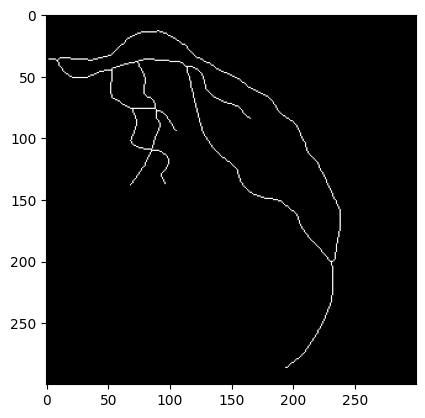

In [1122]:
esqueleto = esqueletizar(prueba1)
plot_image(esqueleto)

In [1123]:
graph = {}

In [1124]:
class Node(object):
    x = 0
    y = 0

    def set_position(self, x, y):
        self.x = x
        self.y = y

    def get_position(self):
        return (self.x, self.y)

In [1125]:
def check_neighbors(x, y, image):
    neighbors = []
    down = False
    up = False
    right = False
    left = False
    # left 
    if x > 0 and image[x-1, y] == 1:
        neighbors.append((x-1, y))
        left = True
    # right
    if x < image.shape[0] - 1 and image[x+1, y] == 1:
        neighbors.append((x+1, y))
        right = True
    # up
    if y > 0 and image[x, y-1] == 1:
        neighbors.append((x, y-1))
        up = True
    # down
    if y < image.shape[1] - 1 and image[x, y+1] == 1:
        neighbors.append((x, y+1))
        down = True
    # upper left
    if x > 0 and y > 0 and image[x-1, y-1] == 1 and not (up or left):
        neighbors.append((x-1, y-1))
    # lower left
    if x > 0 and y < image.shape[1] - 1 and image[x-1, y+1] == 1 and not (down or left):
        neighbors.append((x-1, y+1))
    # upper right
    if x < image.shape[0] - 1 and y > 0 and image[x+1, y-1] == 1 and not (up or right):
        neighbors.append((x+1, y-1))
    # lower right
    if x < image.shape[0] - 1 and y < image.shape[1] - 1 and image[x+1, y+1] == 1 and not (down or right):
        neighbors.append((x+1, y+1))
    return neighbors

In [1126]:

def branchedPoints(skel, showSE=True):
    X=[]
    #cross X
    X0 = np.array([[-1, 1, -1], 
                   [1, 1, 1], 
                   [-1, 1, -1]])
    
    X1 = np.array([[1, -1, 1], 
                   [-1, 1, -1], 
                   [1, -1, 1]])
    
    X2 = np.array([[1, 1, -1], 
                   [-1, 1, -1], 
                   [1, -1, 1]])
    
    X3 = np.array([[-1, 1, 1], 
                   [-1, 1, -1], 
                   [1, -1, 1]])
    
    X4 = np.array([[-1, 1, 1], 
                   [1, 1, -1], 
                   [-1, 1, -1]])
    
    X5 = np.array([[-1, 1, 1], 
                   [-1, 1, 1], 
                   [-1, 1, -1]])
    
    X6 = np.array([[1, 1, -1], 
                   [-1, 1, -1], 
                   [-1, 1, 1]])
    

    X.append(X0)
    X.append(X1)
    X.append(X2)
    X.append(X3)
    X.append(X4)
    X.append(X5)
    X.append(X6)
    #T like
    T=[]
    #T0 contains X0
    T0=np.array([[-1, 1, -1], 
                 [1, 1, 1], 
                 [-1, -1, -1]])

    T1=np.array([[1, -1, 1], 
                 [-1, 1, -1],
                 [1, -1, -1]])  # contains X1

    T2=np.array([[-1, 1, -1], 
                 [1, 1, -1],
                 [-1, 1, -1]])

    T3=np.array([[1, -1, -1],
                 [-1, 1, -1],
                 [1, -1, 1]])

    T4=np.array([[-1, -1, -1],
                 [1, 1, 1],
                 [-1, 1, -1]])

    T5=np.array([[-1, -1, 1], 
                 [-1, 1, -1],
                 [1, -1, 1]])

    T6=np.array([[-1, 1, -1],
                 [-1, 1, 1],
                 [-1, 1, -1]])

    T7=np.array([[1, -1, 1],
                 [-1, 1, -1],
                 [-1, -1, 1]])
    T.append(T0)
    T.append(T1)
    T.append(T2)
    T.append(T3)
    T.append(T4)
    T.append(T5)
    T.append(T6)
    T.append(T7)
    
    TC=np.array([[-1, -1, 1], 
                 [-1, 1, -1], 
                 [1, 1, -1]])
    T.append(TC)
    TC=np.rot90(TC)
    T.append(TC)
    TC=np.rot90(TC)
    T.append(TC)
    TC=np.rot90(TC)
    T.append(TC)
    
    TC=np.array([[1, -1, -1], 
                 [-1, 1, -1], 
                 [-1, 1, 1]])
    T.append(TC)
    TC=np.rot90(TC)
    T.append(TC)
    TC=np.rot90(TC)
    T.append(TC)
    TC=np.rot90(TC)
    T.append(TC)
    
    TC=np.array([[1, 1, 1], 
                 [-1, 1, -1], 
                 [-1, -1, -1]])
    T.append(TC)
    TC=np.rot90(TC)
    T.append(TC)
    TC=np.rot90(TC)
    T.append(TC)
    TC=np.rot90(TC)
    T.append(TC)
    
    
    # TC=np.array([[1, 1, -1], 
    #              [-1, 1, -1], 
    #              [-1, 1, -1]])
    # T.append(TC)
    # TC=np.rot90(TC)
    # T.append(TC)
    # TC=np.rot90(TC)
    # T.append(TC)
    # TC=np.rot90(TC)
    # T.append(TC)
    
    #Y like
    Y=[]
    Y0=np.array([[1, -1, 1], 
                 [-1, 1, -1], 
                 [-1, 1, -1]])

    Y1=np.array([[-1, 1, -1], 
                 [1, 1, -1], 
                 [-1, -1, 1]])

    Y2=np.array([[1, -1, -1], 
                 [-1, 1, 1], 
                 [1, -1, -1]])

    Y3=np.array([[-1, -1, 1], 
                 [1, 1, -1], 
                 [-1, 1, -1]])

    Y4=np.array([[-1, 1, -1], 
                 [-1, 1, -1], 
                 [1, -1, 1]])
    Y5=np.rot90(Y3)
    Y6 = np.rot90(Y4)
    Y7 = np.rot90(Y5)
    Y.append(Y0)
    Y.append(Y1)
    Y.append(Y2)
    Y.append(Y3)
    Y.append(Y4)
    Y.append(Y5)
    Y.append(Y6)
    Y.append(Y7)
    
    return X, T, Y

def endPoints(skel):
    endpoint1=np.array([[-1, -1, -1],
                        [-1, 1, -1],
                        [-1, 1, -1]])

    endpoint2=np.array([[-1, -1, -1],
                        [-1, 1, -1],
                        [-1, -1, 1]])

    endpoint3=np.array([[-1, -1, -1],
                        [-1, 1, 1],
                        [-1, -1, -1]])

    endpoint4=np.array([[-1, -1, 1],
                        [-1, 1, -1],
                        [-1, -1, -1]])

    endpoint5=np.array([[-1, 1, -1],
                        [-1, 1, -1],
                        [-1, -1, -1]])

    endpoint6=np.array([[1, -1, -1],
                        [-1, 1, -1],
                        [-1, -1, -1]])

    endpoint7=np.array([[-1, -1, -1],
                        [1, 1, -1],
                        [-1, -1, -1]])

    endpoint8=np.array([[-1, -1, -1],
                        [-1, 1, -1],
                        [1, -1, -1]])

    return[endpoint1, endpoint2, endpoint3, endpoint4, endpoint5, endpoint6, endpoint7, endpoint8]

In [1127]:
def get_points(skel, showSE=True):
    X, T, Y = branchedPoints(skel)
    endpoints = endPoints(skel)
    bifurcation = []
    trifurcation = []
    end_points = []
    for end_point in endpoints:
        result = cv2.morphologyEx(skel, cv2.MORPH_HITMISS, end_point)
        indices = np.argwhere(result == 1)
        end_points.extend(indices)
    
    for x in X:
        result = cv2.morphologyEx(skel, cv2.MORPH_HITMISS, x)
        indices = np.argwhere(result == 1)
        trifurcation.extend(indices)
    
    for t in T:
        result = cv2.morphologyEx(skel, cv2.MORPH_HITMISS, t)
        indices = np.argwhere(result == 1)
        bifurcation.extend(indices)
    
    for y in Y:
        result = cv2.morphologyEx(skel, cv2.MORPH_HITMISS, y)
        indices = np.argwhere(result == 1)
        bifurcation.extend(indices)
        
    return bifurcation, trifurcation, end_points
    
        

In [1128]:
def construct_graph(imagen):
    imagen = imagen.copy()
    intemediate = []
    cont = 0
    mod = 45
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            if imagen[i][j] == 1:
                node = Node()
                node.set_position(i, j)
                graph[(i, j)] = node
                neighbors = check_neighbors(i, j, imagen)
                if len(neighbors) == 2:
                    if cont % mod == 0:
                        intemediate.append((i, j))
                cont += 1   
                
    return graph, *get_points(imagen), intemediate

In [1129]:
_, bifurcation, trifurcation, end_points, intermediate = construct_graph(esqueleto)

# Convertir arrays de NumPy a listas
bifurcation = np.unique(bifurcation, axis=0).tolist()
trifurcation = np.unique(trifurcation, axis=0).tolist()
end_points = np.unique(end_points, axis=0).tolist()

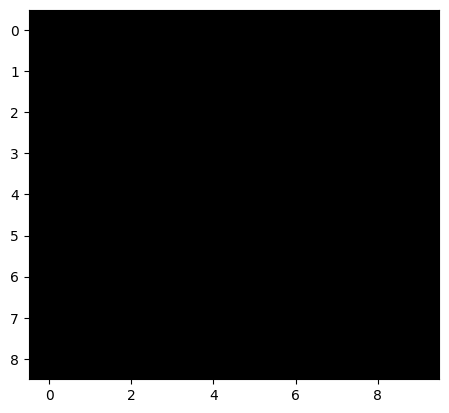

In [1130]:
# temp = esqueleto[28:35, 160:170]
# temp = esqueleto[28:35, 160:170]
temp = esqueleto[41:50, 220:230]
# print(temp)
plot_image(temp)

In [1131]:
def join_points(window_len,array):
    new_array = []
    for element in array:
        matriz = [[0] * window_len for _ in range(window_len)]
        x, y = element
        for i in range(window_len):
            for j in range(window_len):
                matriz[i][j] = [x - window_len//2 + i,y - window_len//2 + j]
        for fila in matriz:
            for vecino in fila:
                if vecino in array and vecino != element:
                    avg = [(vecino[0] + x)//2, (vecino[1] + y)//2]
                    array.remove(vecino)
                    if (x, y) in array:
                        array.remove((x, y))
                    new_array.append(avg)
    return array,new_array


[[37, 8], [37, 9], [38, 9], [38, 74], [39, 74], [42, 113], [42, 114], [44, 53], [45, 53], [76, 70], [76, 88], [77, 89], [78, 89], [111, 85], [200, 230], [200, 231], [200, 232]]


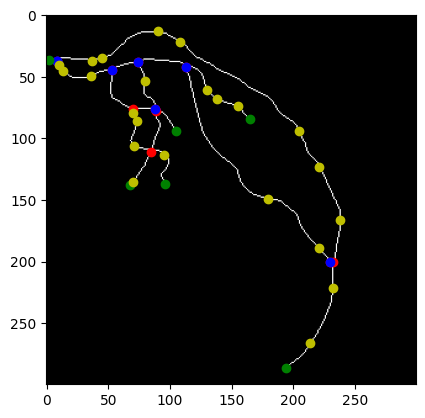

In [1132]:
print(bifurcation)
cuatrifurcation = []
ventana = 3
plt.imshow(esqueleto, cmap='gray')
bifurcation, new_trifurcation = join_points(ventana,bifurcation)

if len(new_trifurcation) > 0:
    if len(trifurcation) > 1:
        trifurcation.append(new_trifurcation)
    else:
        trifurcation.extend(new_trifurcation)


trifurcation, new_cuatrifurcation = join_points(ventana,trifurcation)
if len(new_cuatrifurcation) > 0:
    if len(cuatrifurcation) > 1:
        cuatrifurcation.append(new_cuatrifurcation)
    else:
        cuatrifurcation.extend(new_cuatrifurcation)

x = [coord[1] for coord in bifurcation]
y = [coord[0] for coord in bifurcation]
plt.plot(x, y, 'ro')

x2 = [coord[1] for coord in trifurcation]
y2 = [coord[0] for coord in trifurcation]
plt.plot(x2, y2, 'bo')

x3 = [coord[1] for coord in end_points]
y3 = [coord[0] for coord in end_points]
plt.plot(x3, y3, 'go')

x4 = [coord[1] for coord in intermediate]
y4 = [coord[0] for coord in intermediate]
plt.plot(x4, y4, 'yo')



plt.show()

In [1133]:
result = bifurcation + trifurcation + end_points + intermediate

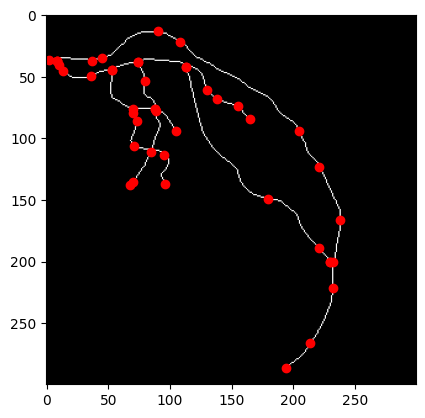

In [1134]:
x = [coord[1] for coord in result]
y = [coord[0] for coord in result]
plt.plot(x, y, 'ro')
plt.imshow(esqueleto, cmap='gray')
plt.show()

28


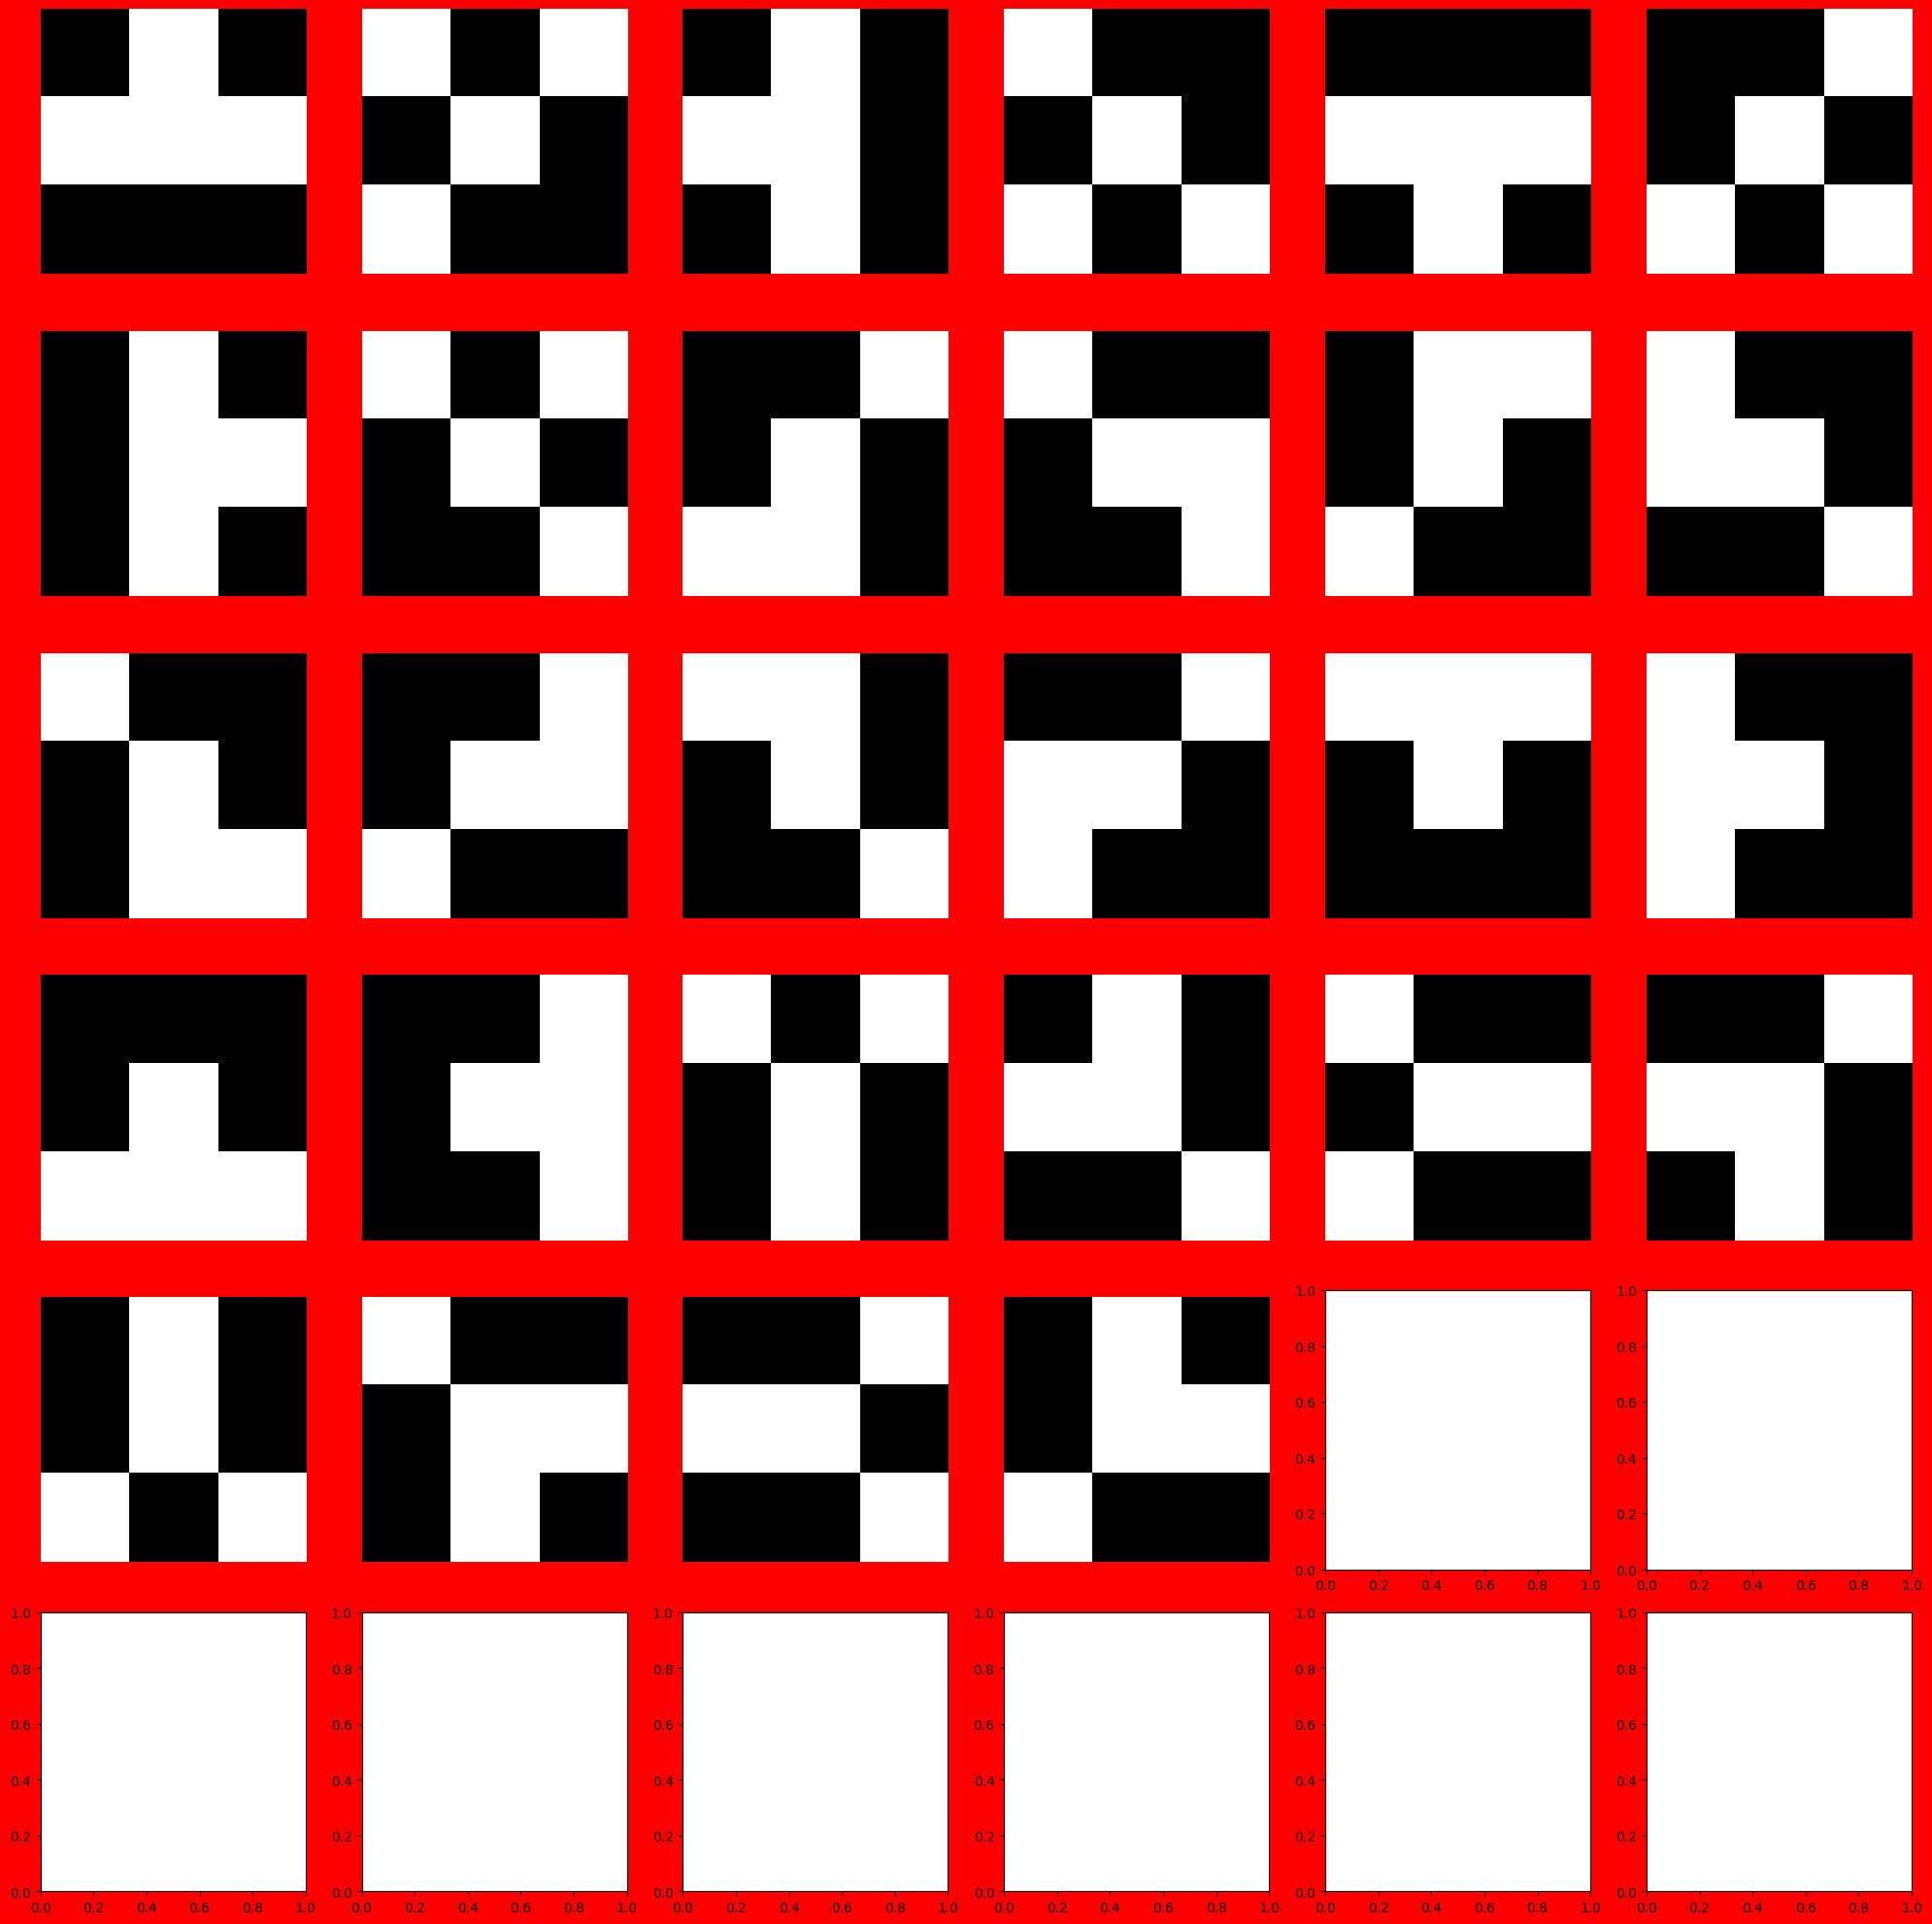

In [1135]:
X, T, Y = branchedPoints(esqueleto)

F = T + Y
print(len(F))
num_filas = 6  # Puedes ajustar según sea necesario
num_columnas = 6
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(20, 20))

# Itera sobre los elementos en Y y muéstralos en los subgráficos
for i in range(num_filas):
    for j in range(num_columnas):
        if len(F) <= i * num_columnas + j:
            break
        axs[i, j].imshow(F[i * num_columnas + j], cmap='gray')
        axs[i, j].axis('off')  # Opcional: desactiva los ejes para una apariencia más limpia

# Ajusta el diseño para evitar solapamientos
plt.tight_layout()
fig.set_facecolor('red')
# Muestra la cuadrícula
plt.show()